In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # on NERSC filelocking is not allowed
import h5py
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
import pickle as pkl
from matplotlib import pyplot as plt

import tensorflow as tf
# Make notebook run on other GPUS. GPT's solution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[1], 'GPU')  # change 1 to 0, 2, 3 as needed
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import sys
# Path to dir model.py lives in -------
# NOTE: This needs to be modified to where your repo lives, path to /repo/path/VAE_FS/models/
# If the jupyter notebook kernel is running from VAE_FS/models/ the

# line below is not needed
sys.path.append('/global/homes/j/jananinf/projs/VAE_FS/models/')

# import the custom models and functions
from models import Qmake_encoder_set_weights, Qmake_decoder_set_weights, Qmake_discriminator, VAE_GAN_Model
from data_and_eval_utils import load_preprocessed_snl

# in gan1. We train the VAE_GAN model

2025-07-31 16:00:56.204483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-31 16:00:57.769678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from gan_params import * # import base parameters and display them
print_base_params()

CONSTANTS IMPORTED:
            NUM_TRAIN      = 10 # Number of iterations to train for.
            # VAE Architecture
            INPUT_SZ       = 57
            H1_SZ          = 32 # Hidden layer 1 size
            H2_SZ          = 16 # "          " 2 "  "
            LATENT_SZ      = 3
            # Discriminator Architecture # 8, 2 is on ATLAS-VAE-GAN
            DISC_H1_SZ     = 8 # Size of first hidden layer of discriminator  
            DISC_H2_SZ     = 2 # "" second hidden layer ""
            # Training schedule and parameters
            NUM_EPOCHS     = 100
            STEPS_EPOCH    = 20 # Steps per epoch
            BATCH_SIZE     = 1024
            STOP_PATIENCE  = 40
            LR_PATIENCE    = 20
            LR             = 0.001 # Learning rate
            REDUCE_LR_FACTOR = 0.5
            VAL_SPLIT      = 0.2 # Validation split
            CYCLE_LEN      = 20
            SHUFFLE_BOOL   = True
            # Hyperparameters
            MIN_BETA       = 0
          

In [ ]:
# Overriden parameters
ATTEMPT_NUM = 23 # max gamma decreased, min gamma decreased
MIN_GAMMA      = 0
MAX_GAMMA      = 1.5
LR             = 0.000001 # Learning rate

In [4]:
# Load data
home_path = "/global/cfs/cdirs/m2616/jananinf/projsIO/VAE_FS/" # Updated to NERSC
data = load_preprocessed_snl()
X_train = data['X_train']

Data loaded from preprocessed_SNL_data.h5


### Simple training loop. No parameter sweeping

In [5]:
train = True
save = True
SAVE_PATH = home_path+f"/GAN_trainings/attempt{ATTEMPT_NUM}/" 
early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=LR, patience=LR_PATIENCE, verbose=1)

for i in range(NUM_TRAIN):
    if train:
        tf.keras.backend.clear_session()

        print(f"TRAINING ITERATION {i} ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
        enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
        dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
        disc = Qmake_discriminator(INPUT_SZ, DISC_H1_SZ, DISC_H2_SZ) # Modified this to the ATLAS-VAE-GAN

        steps_per_epoch = X_train.shape[0] // BATCH_SIZE
        
        # Modified these setting to match atlas VAE gan repo
        vae = VAE_GAN_Model(
                            enc
                            ,dec
                            ,disc
                            ,cycle_length=CYCLE_LEN
                            ,min_beta=MIN_BETA
                            ,max_beta=MAX_BETA
                            ,min_gamma=MIN_GAMMA
                            ,max_gamma=MAX_GAMMA
                            ,max_epochs=NUM_EPOCHS
                            ,steps_per_epoch=STEPS_EPOCH
                            )
        opt = keras.optimizers.Adam(learning_rate=LR)
        # --
        vae.compile(optimizer=opt)
        history = vae.fit(x=X_train, validation_split=VAL_SPLIT, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping,reduce_lr], shuffle=SHUFFLE_BOOL)

        
        # Iterative training. 
        save_path = SAVE_PATH+f"n_{i}/" 
        if save:
            print(f"SAVING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            vae.save_weights(filepath=save_path, save_format='tf')

            # Now save the histories
            with open(save_path + f"training_history.pkl", 'wb') as f:
                pkl.dump(history.history, f)

TRAINING ITERATION 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



2025-07-31 16:01:05.986782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


Epoch 1/100


2025-07-31 16:01:08.307272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-07-31 16:01:08.426365: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5585d5267820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-31 16:01:08.426385: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-07-31 16:01:08.430683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 16:01:08.461079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2025-07-31 16:01:08.602735: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

2500/2500 [==============================] - 16s 5ms/step - loss: 1.5297 - reco_loss: 1.6793 - kl_loss: 0.1247 - disc_loss: 0.8512 - d_loss: 1.3620 - raw_loss: 2.0278 - w_kl_loss: 0.2488 - w_disc_loss: 1.4638 - beta: 0.9900 - gamma: 1.8750 - val_loss: 3.8225 - val_reco_loss: 1.2145 - val_kl_loss: 0.0103 - val_d_loss: 1.3865 - val_raw_loss: 1.2249 - val_disc_loss: 0.6930 - val_w_kl_loss: 0.0102 - val_w_disc_loss: 2.5978 - val_gamma: 3.7485 - val_beta: 0.9900 - lr: 0.0010
Epoch 2/100
2500/2500 [==============================] - 11s 5ms/step - loss: 3.4868 - reco_loss: 0.9980 - kl_loss: 0.0146 - disc_loss: 0.6931 - d_loss: 1.3863 - raw_loss: 1.0141 - w_kl_loss: 0.0121 - w_disc_loss: 3.8988 - beta: 1.0000 - gamma: 5.6250 - val_loss: 6.4053 - val_reco_loss: 1.2060 - val_kl_loss: 0.0019 - val_d_loss: 1.3863 - val_raw_loss: 1.2079 - val_disc_loss: 0.6931 - val_w_kl_loss: 0.0019 - val_w_disc_loss: 5.1974 - val_gamma: 7.4985 - val_beta: 1.0000 - lr: 0.0010
Epoch 3/100
2500/2500 [===============

Plot Loss vs epoch history.

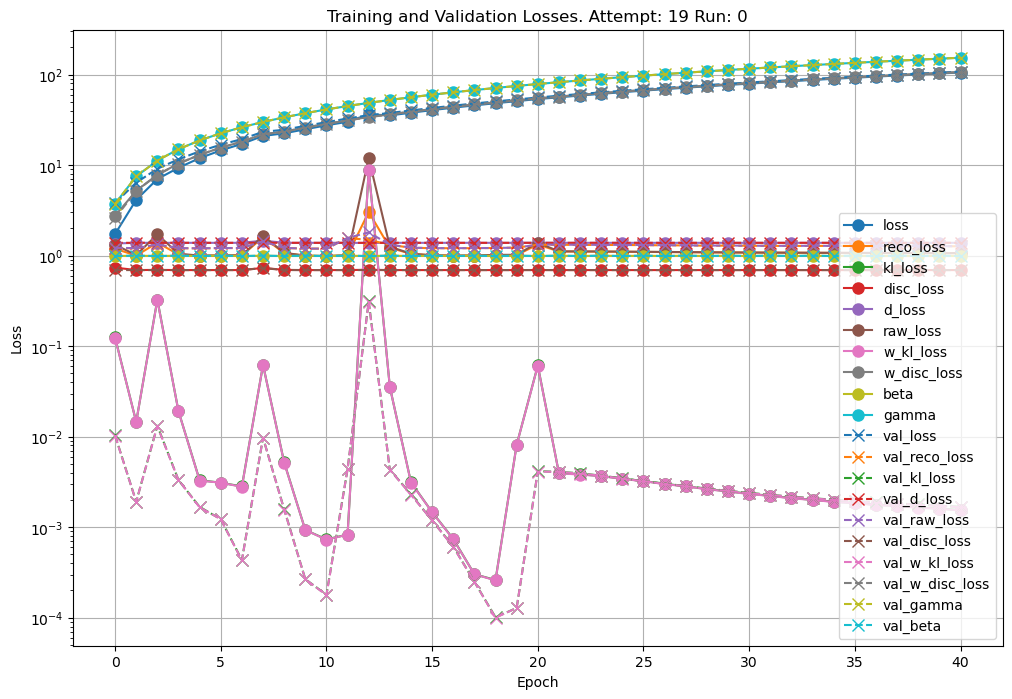

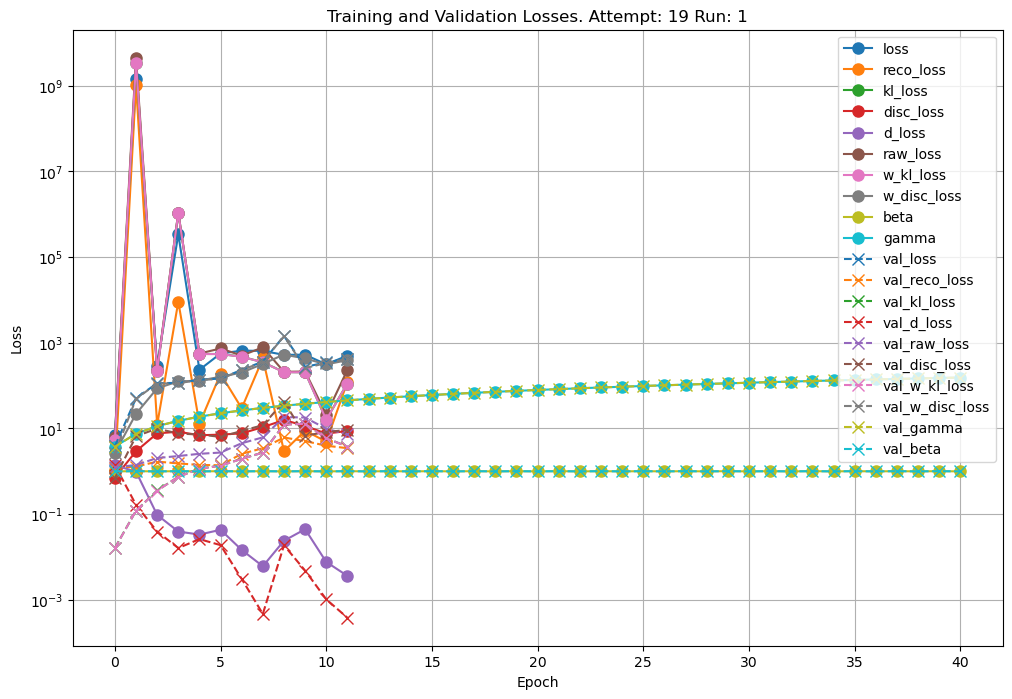

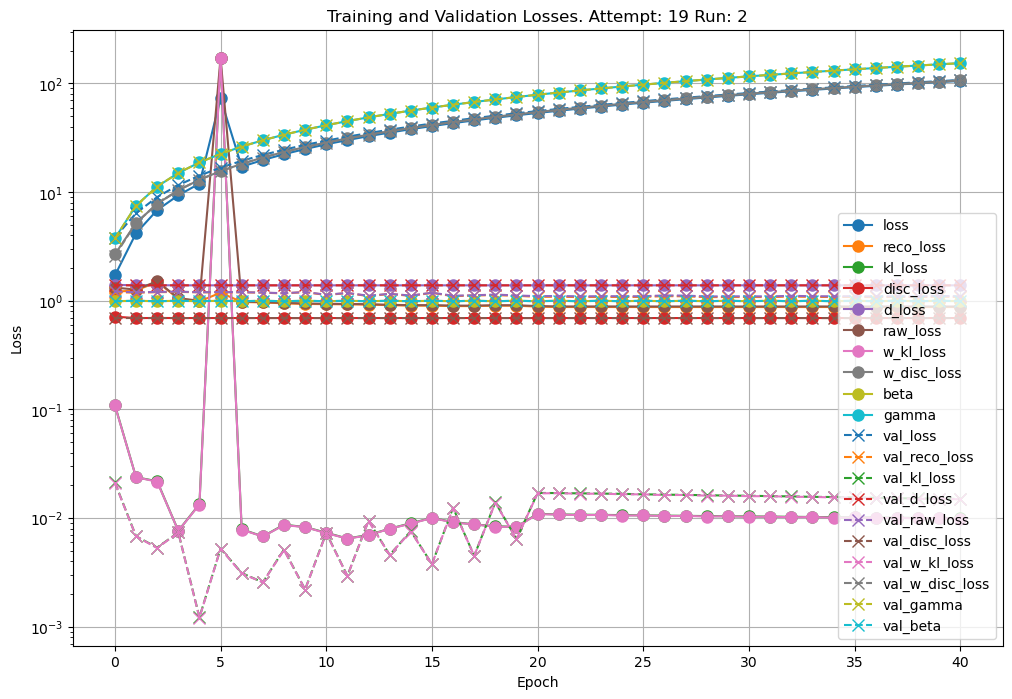

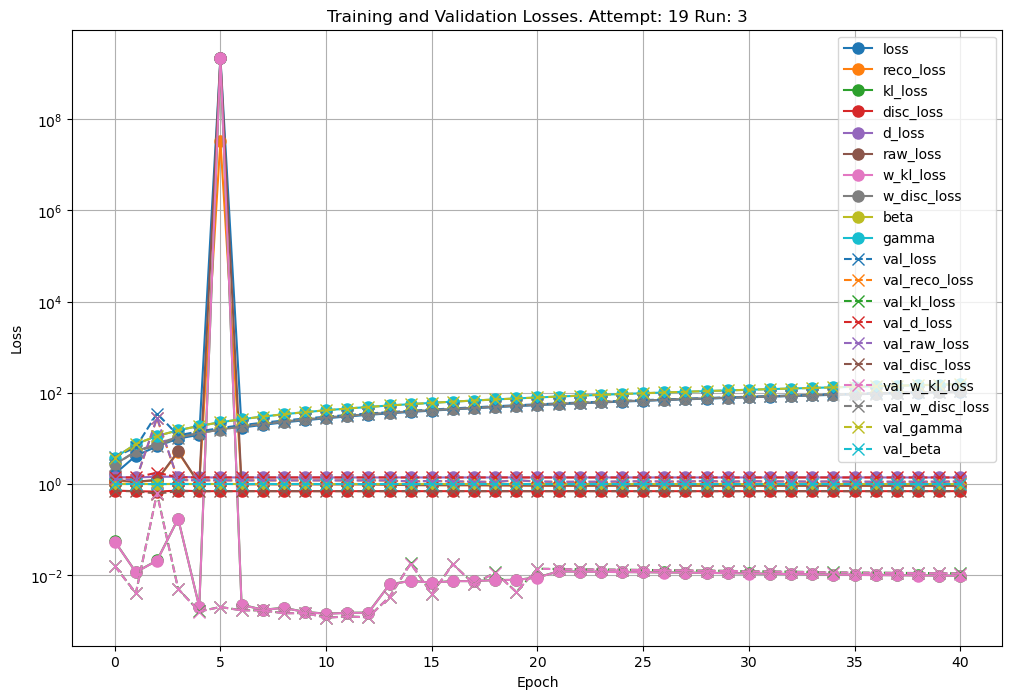

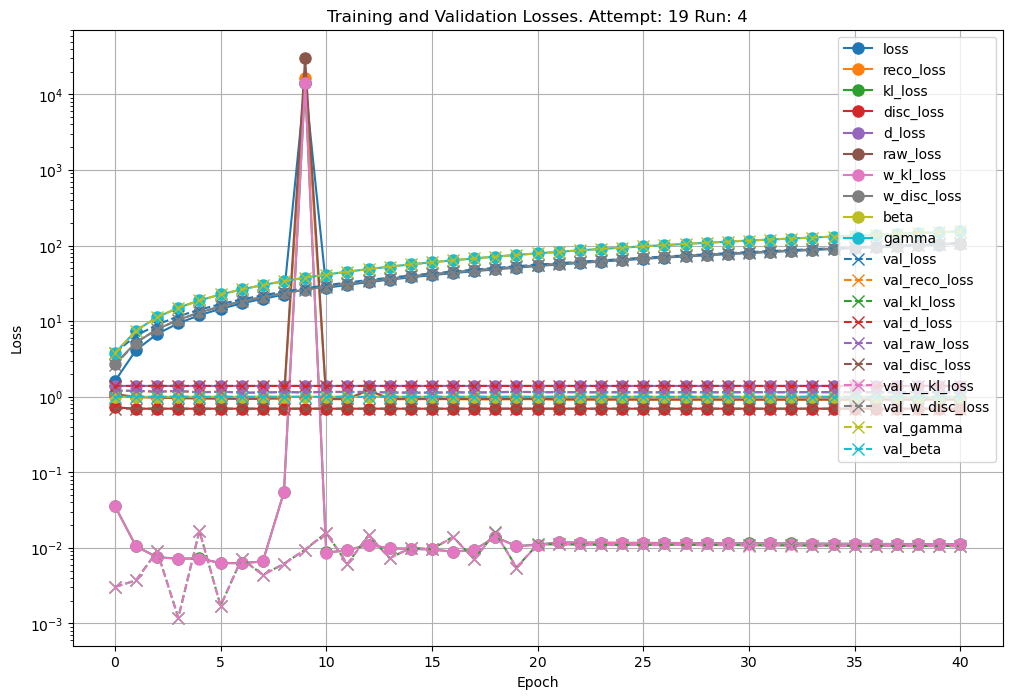

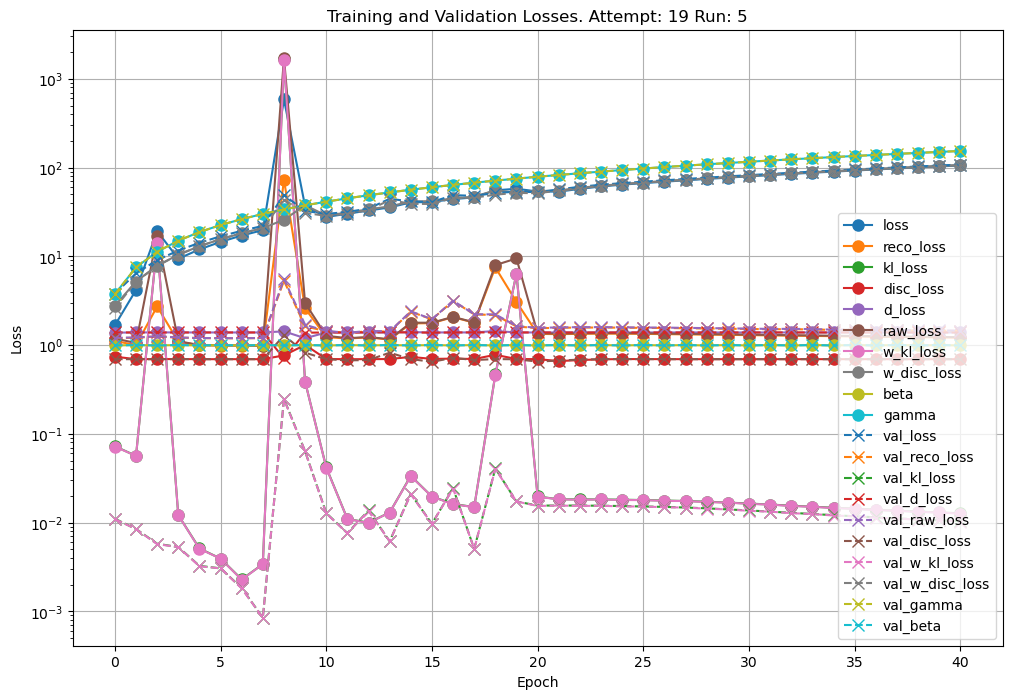

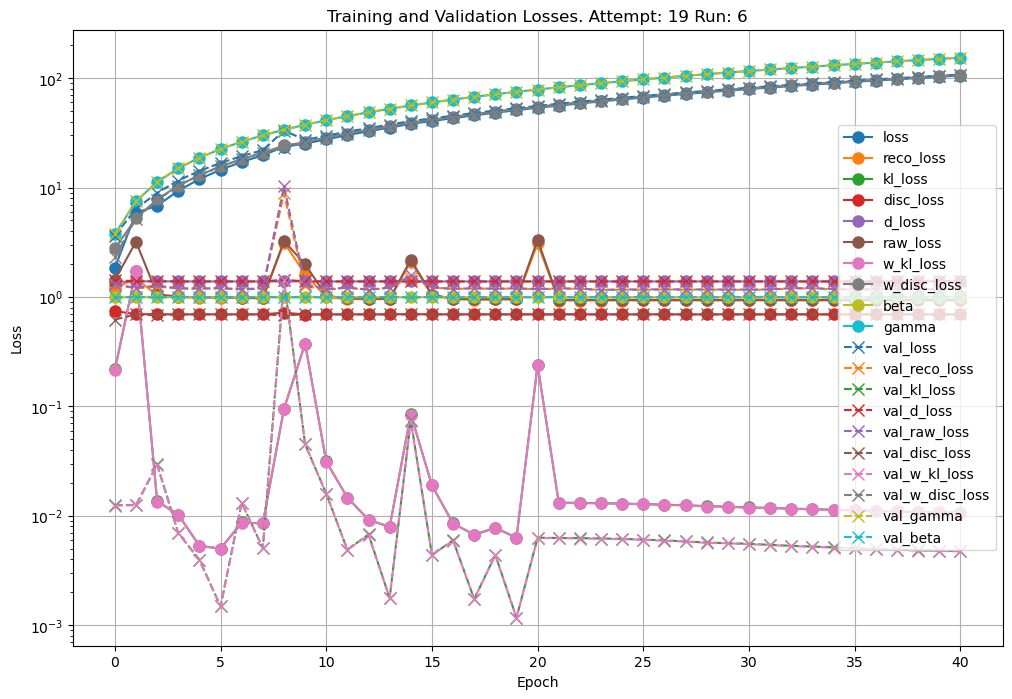

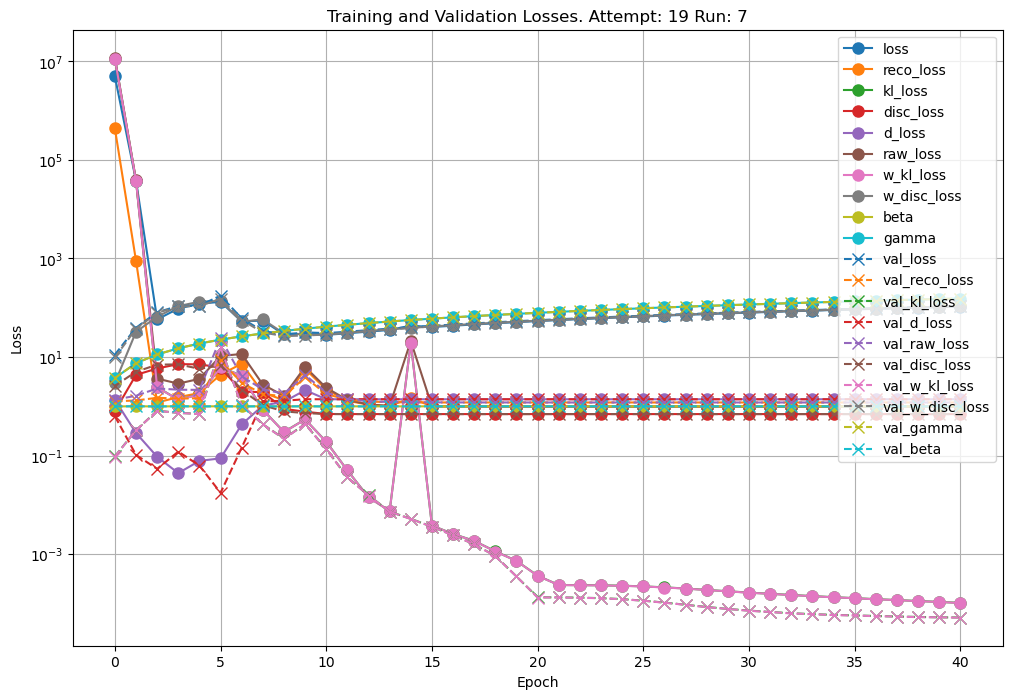

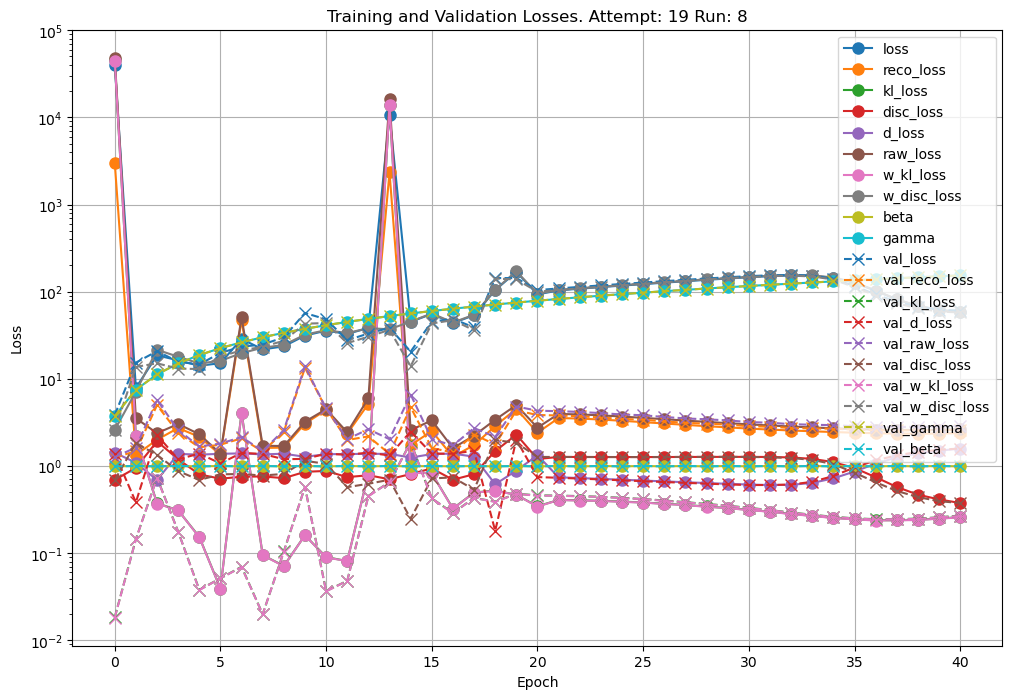

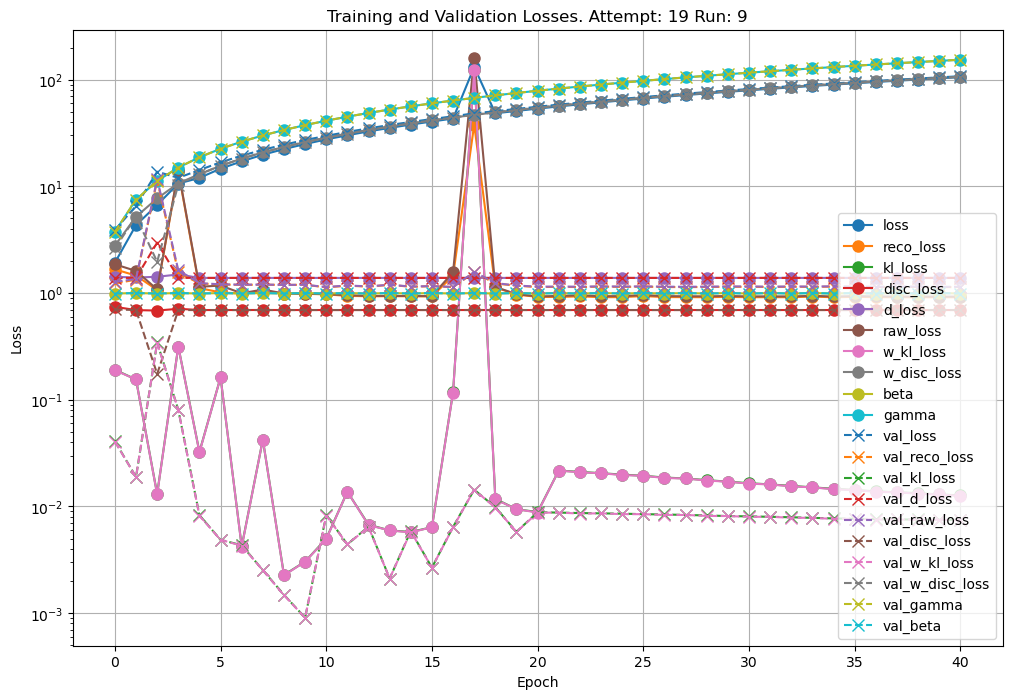

In [ ]:
# Quick and dirty Loss plots while we're at it
skipped_keys = ['reco_loss'         # VAE loss term
                ,'kl_loss'           # VAE Loss term
                ,'disc_loss'         # VAE loss due to discriminator "failure to fool disc"
                ,'raw_loss'          # Reco_loss + kl_loss
                ,'w_kl_loss'         # kl_loss * beta
                ,'w_disc_loss'       # disc_loss * gamma
                ,'val_reco_loss'
                ,'val_kl_loss'
                ,'val_disc_loss'
                ,'val_raw_loss'
                ,'val_w_kl_loss'
                ,'val_w_disc_loss'
                ,'beta'              # hyperparameter
                ,'gamma'             # hyperparameter
                ,'val_gamma'         # hyperparameter
                ,'val_beta'          # hyperparameter
                ,'lr'              # learning rate
             ]
for i in range(NUM_TRAIN):
    save_path = SAVE_PATH + f"n_{i}/"
    with open(save_path + 'training_history.pkl', 'rb') as f:
        history = pkl.load(f)

    
    # Plot training losses
    plt.figure(figsize=(12, 8))
    for key, val in history.items():
        if key in skipped_keys:
            continue
        plt.plot(val, label=key, 
                 linestyle = "dashed" if key[0:3] == 'val' else "solid",
                 marker= "x" if key[0:3] == 'val' else "o",
                 markersize=8) 


    # Customize the plot
    plt.title(f'Training and Validation Losses. Attempt: {ATTEMPT_NUM} Run: {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.semilogy()

    # Show the plot
    plt.show()